<a href="https://colab.research.google.com/github/Layna9989/Unsupervised-Learning-for-Customer-Segmentation/blob/main/Unsupervised_Learning_for_Customer_Segmentation_and_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
from google.colab import drive
drive.mount('/content/drive')
import  pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors



from sklearn.cluster import AgglomerativeClustering


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
file_path = "/content/drive/MyDrive/Datasets/CC GENERAL.csv"

df = pd.read_csv(file_path)
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


# data preprocissing

In [13]:
#معاينة بنية البيانات والقيم المفقودة
# نظرة سريعة على الأعمدة وأنواعها وعدد القيم غير الفارغة
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [12]:
# عدد القيم الفارغة في كل عمود
df.isna().sum()

,0
CUST_ID,0
BALANCE,0
BALANCE_FREQUENCY,0
PURCHASES,0
ONEOFF_PURCHASES,0
INSTALLMENTS_PURCHASES,0
CASH_ADVANCE,0
PURCHASES_FREQUENCY,0
ONEOFF_PURCHASES_FREQUENCY,0
PURCHASES_INSTALLMENTS_FREQUENCY,0


In [14]:
#معالجة القيم المفقودة
for col in ["MINIMUM_PAYMENTS", "CREDIT_LIMIT"]:
    median = df[col].median()
    df[col].fillna(median, inplace=True)

# تأكد
df[["MINIMUM_PAYMENTS", "CREDIT_LIMIT"]].isna().sum()

/tmp/ipython-input-14-2207174202.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median, inplace=True)


,0
MINIMUM_PAYMENTS,0
CREDIT_LIMIT,0


In [15]:
# نستخدم طريقة IQR لتحديد القيم المتطرفة في العمود BALANCE كمثال
Q1 = df["BALANCE"].quantile(0.25)
Q3 = df["BALANCE"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# أسطر خارج الحدود
outliers = df[(df["BALANCE"] < lower_bound) | (df["BALANCE"] > upper_bound)]
print("عدد القيم المتطرفة في BALANCE:", len(outliers))

# إذا أردت حذفها:
# df = df[(df["BALANCE"] >= lower_bound) & (df["BALANCE"] <= upper_bound)]


عدد القيم المتطرفة في BALANCE: 695


In [18]:
#الكود هنا وظيفته تقييس (standardize) جميع المتغيرات الرقمية عدا الـCUST_ID حتى تصير:
#متوسط كل عمود = 0
#الانحراف المعياري لكل عمود = 1

# نستثني CUST_ID لأنّه فئوي
features = df.drop("CUST_ID", axis=1)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# نحولها إلى DataFrame مع الاحتفاظ بالأسماء
df_scaled = pd.DataFrame(features_scaled, columns=features.columns)

df_scaled.head()


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,-0.731989,-0.249434,-0.424900,-0.356934,-0.349079,-0.466786,-0.806490,-0.678661,-0.707313,-0.675349,-0.476070,-0.511333,-0.960378,-0.528979,-0.302400,-0.525551,0.36068
1,0.786961,0.134325,-0.469552,-0.356934,-0.454576,2.605605,-1.221758,-0.678661,-0.916995,0.573963,0.110074,-0.591796,0.688678,0.818642,0.097500,0.234227,0.36068
2,0.447135,0.518084,-0.107668,0.108889,-0.454576,-0.466786,1.269843,2.673451,-0.916995,-0.675349,-0.476070,-0.109020,0.826100,-0.383805,-0.093293,-0.525551,0.36068
3,0.049099,-1.016953,0.232058,0.546189,-0.454576,-0.368653,-1.014125,-0.399319,-0.916995,-0.258913,-0.329534,-0.551565,0.826100,-0.598688,-0.228307,-0.525551,0.36068
4,-0.358775,0.518084,-0.462063,-0.347294,-0.454576,-0.466786,-1.014125,-0.399319,-0.916995,-0.675349,-0.476070,-0.551565,-0.905410,-0.364368,-0.257266,-0.525551,0.36068


# Exploratory Data Analysis (EDA)

In [24]:
#نظرة عامة وصفية (Descriptive Statistics)
# ملخص عام للإحصائيات الوصفية
display(df.describe().T)


,count,mean,std,min,25%,50%,75%,max
BALANCE,8950.0,1564.474828,2081.531879,0.000000,128.281915,873.385231,2054.140036,19043.13856
BALANCE_FREQUENCY,8950.0,0.877271,0.236904,0.000000,0.888889,1.000000,1.000000,1.00000
PURCHASES,8950.0,1003.204834,2136.634782,0.000000,39.635000,361.280000,1110.130000,49039.57000
ONEOFF_PURCHASES,8950.0,592.437371,1659.887917,0.000000,0.000000,38.000000,577.405000,40761.25000
INSTALLMENTS_PURCHASES,8950.0,411.067645,904.338115,0.000000,0.000000,89.000000,468.637500,22500.00000
CASH_ADVANCE,8950.0,978.871112,2097.163877,0.000000,0.000000,0.000000,1113.821139,47137.21176
PURCHASES_FREQUENCY,8950.0,0.490351,0.401371,0.000000,0.083333,0.500000,0.916667,1.00000
ONEOFF_PURCHASES_FREQUENCY,8950.0,0.202458,0.298336,0.000000,0.000000,0.083333,0.300000,1.00000
PURCHASES_INSTALLMENTS_FREQUENCY,8950.0,0.364437,0.397448,0.000000,0.000000,0.166667,0.750000,1.00000
CASH_ADVANCE_FREQUENCY,8950.0,0.135144,0.200121,0.000000,0.000000,0.000000,0.222222,1.50000


In [23]:
df.isna().sum()

,0
CUST_ID,0
BALANCE,0
BALANCE_FREQUENCY,0
PURCHASES,0
ONEOFF_PURCHASES,0
INSTALLMENTS_PURCHASES,0
CASH_ADVANCE,0
PURCHASES_FREQUENCY,0
ONEOFF_PURCHASES_FREQUENCY,0
PURCHASES_INSTALLMENTS_FREQUENCY,0


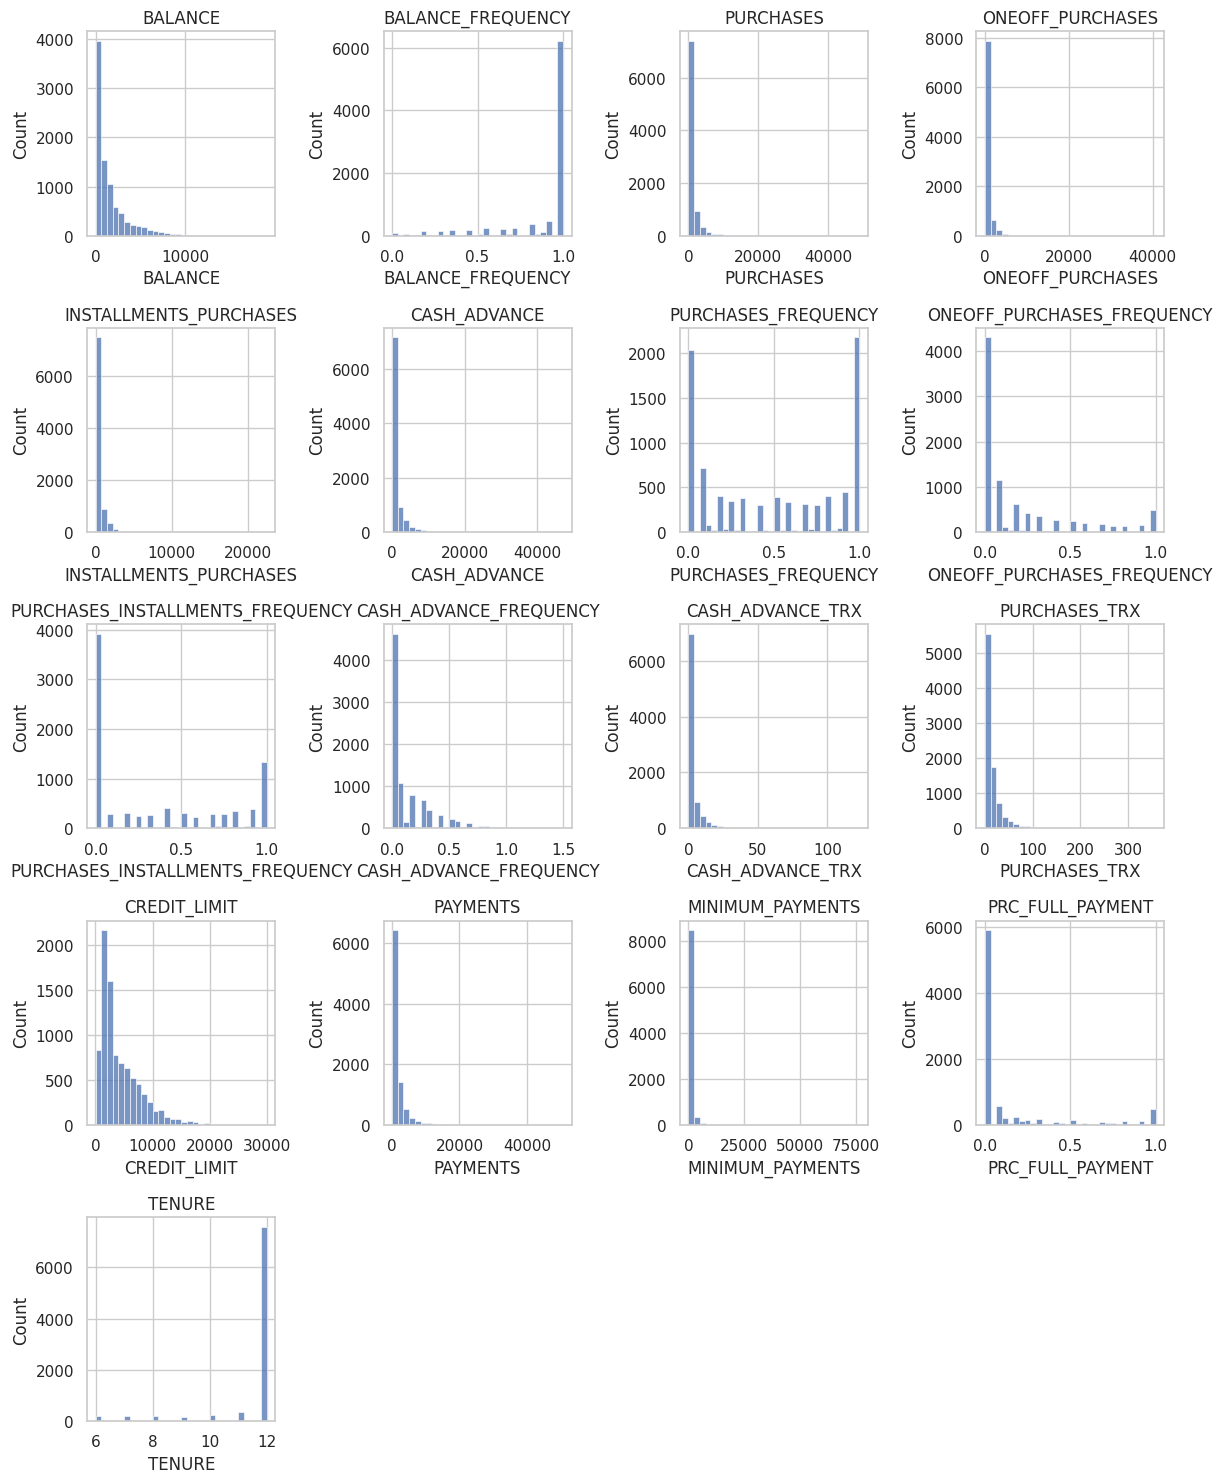

In [28]:
#هيستوجرامات للمتغيرات الرئيسية
# خذ كل الأعمدة الرقمية ما عدا CUST_ID
import math

numeric_cols = [col for col in df.columns
                if col!="CUST_ID" and pd.api.types.is_numeric_dtype(df[col])]

n = len(numeric_cols)
n_cols = 4
n_rows = math.ceil(n / n_cols)

plt.figure(figsize=(12, n_rows*3))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df[col], bins=30, kde=False)
    plt.title(col)
plt.tight_layout()
plt.show()




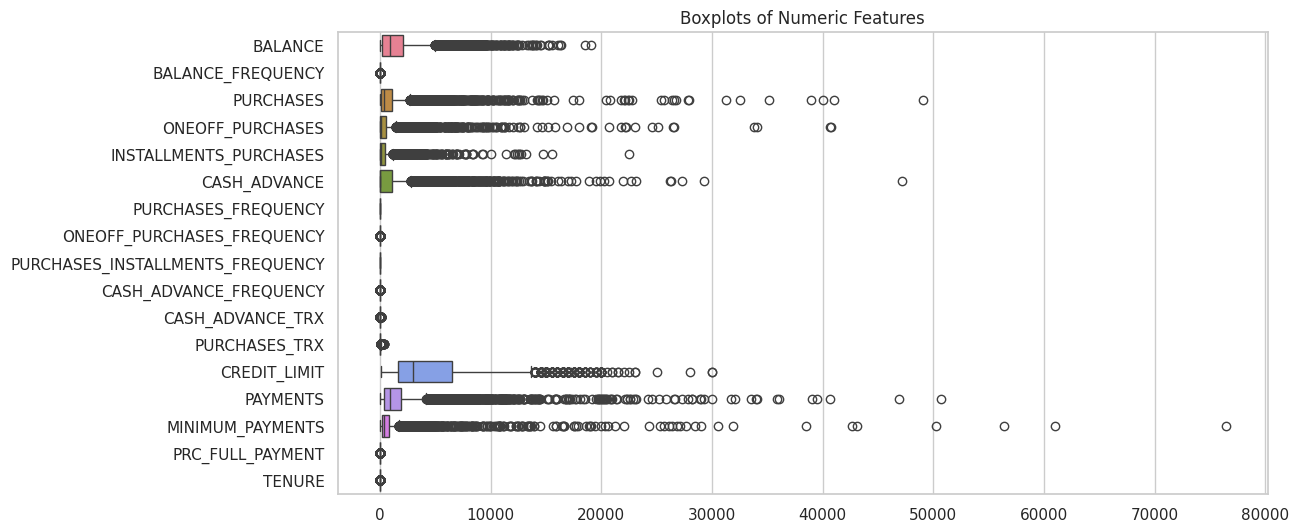

In [29]:
#box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numeric_cols], orient="h")
plt.title("Boxplots of Numeric Features")
plt.show()


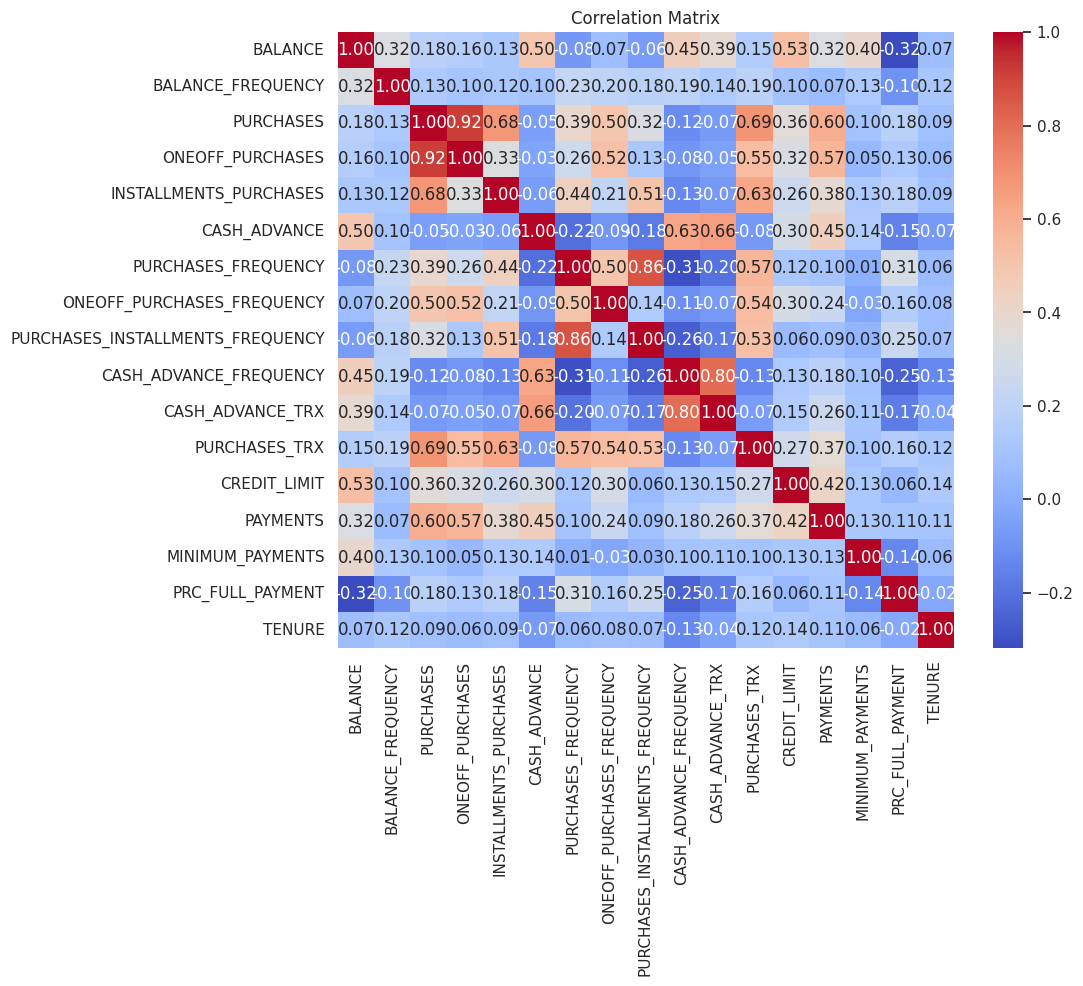

In [30]:
#correltion matrix
plt.figure(figsize=(10, 8))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.show()


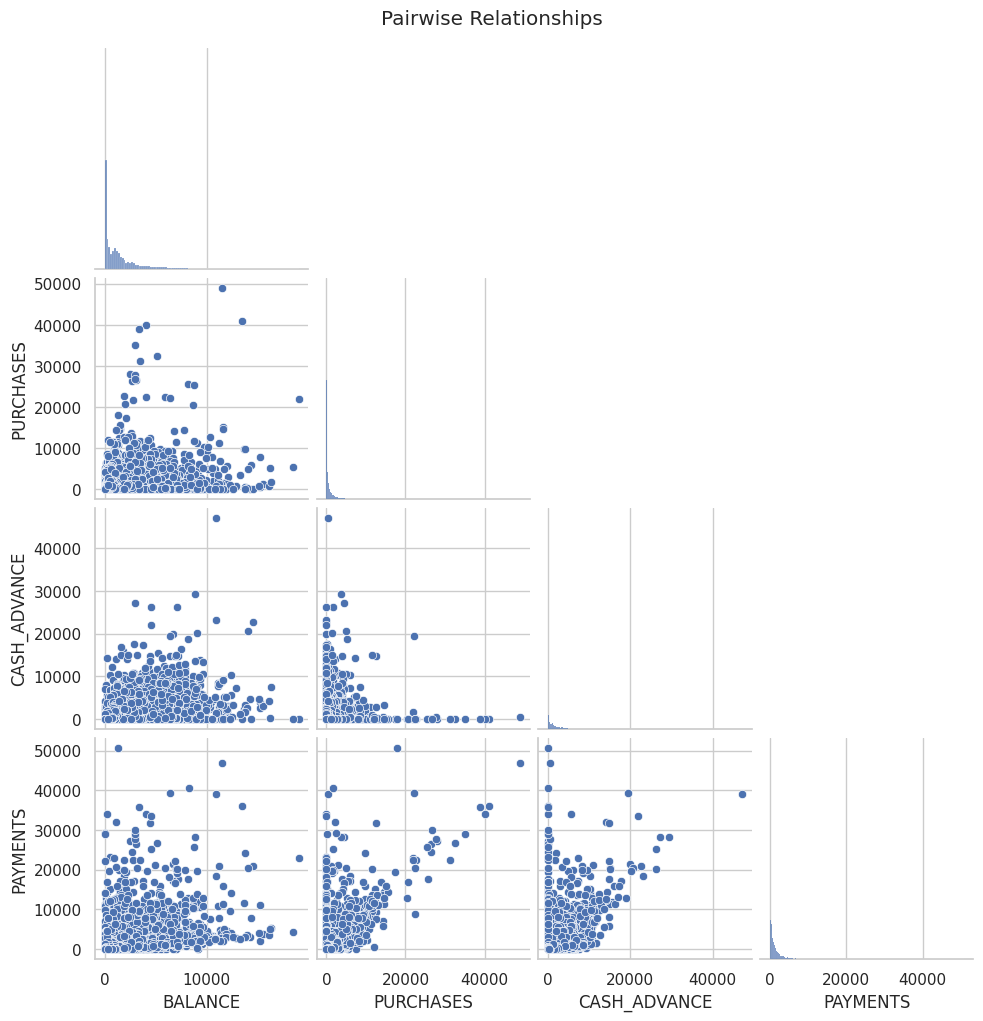

In [31]:
# نختار بعض المتغيرات المهمة للمقارنة
subset = ["BALANCE", "PURCHASES", "CASH_ADVANCE", "PAYMENTS"]
sns.pairplot(df[subset], diag_kind="hist", corner=True)
plt.suptitle("Pairwise Relationships", y=1.02)
plt.show()

# Apply Unsupervised Learning Algorithms

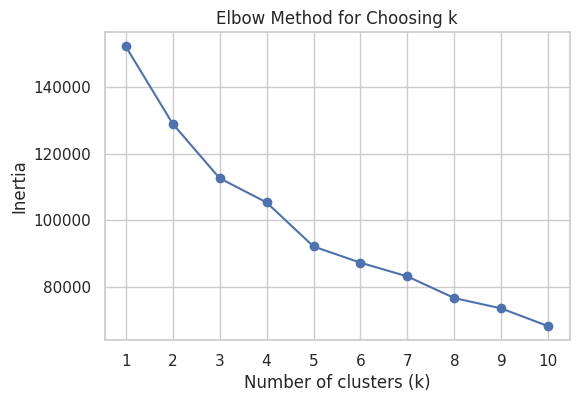

In [36]:

# ╔═ Cell B: Elbow Method for determining k
inertias = []
k_values = range(1, 11)

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42).fit(df_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Choosing k')
plt.xticks(k_values)
plt.show()


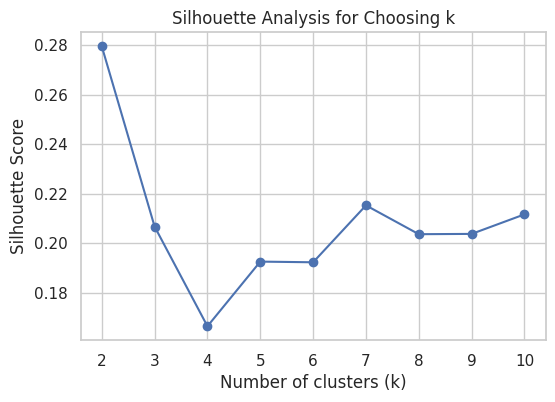

In [41]:
silhouette_scores = []
k_values = range(2, 11)
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42).fit(df_scaled)
    silhouette_scores.append(silhouette_score(df_scaled, km.labels_))

plt.figure(figsize=(6,4))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Choosing k')
plt.xticks(k_values)
plt.show()


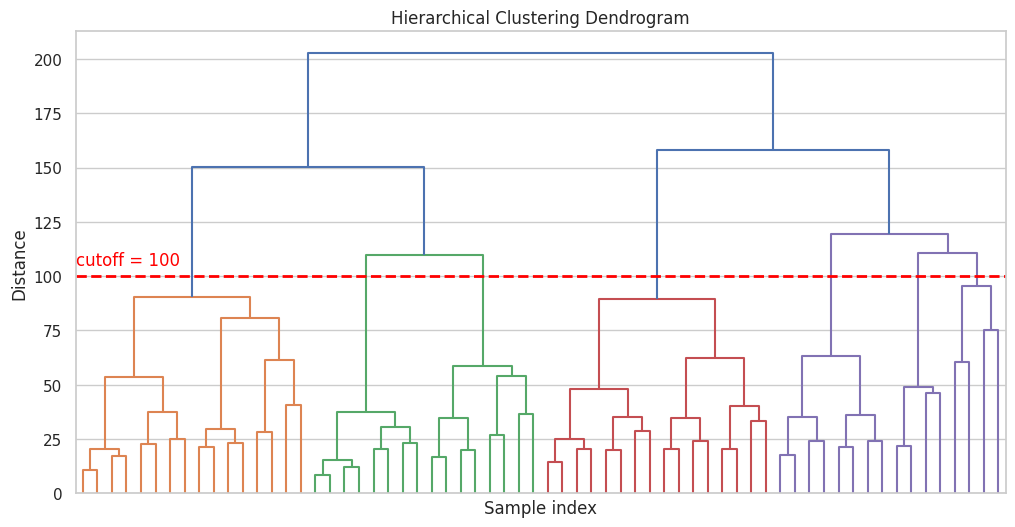

In [44]:
# ╔═ Cell: Plot dendrogram with horizontal cutoff line
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Compute linkage matrix
Z = linkage(df_scaled, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='level', p=5, no_labels=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')

# Draw cutoff line at distance = 100 (adjust as needed)
cutoff = 100
plt.axhline(y=cutoff, color='red', linestyle='--', linewidth=2)
plt.text(0, cutoff + 5, f'cutoff = {cutoff}', color='red')

plt.show()


In [42]:
# 1️⃣ Choose your number of clusters (e.g. k = 4 after Elbow/Silhouette)
k = 4

# 2️⃣ Fit KMeans on your scaled features (df_scaled)
kmeans = KMeans(n_clusters=k, random_state=42)
labels_kmeans = kmeans.fit_predict(df_scaled)

# 3️⃣ Attach cluster labels back to your original DataFrame
df['cluster_kmeans'] = labels_kmeans

# 4️⃣ Inspect results
print("Inertia:", kmeans.inertia_)
print(df['cluster_kmeans'].value_counts())

# Optional: view cluster centers (in scaled space)
print("Cluster centers (scaled):\n", pd.DataFrame(kmeans.cluster_centers_, columns=df_scaled.columns))

Inertia: 105339.67513964884
cluster_kmeans
3    3368
2    3118
1    1487
0     977
Name: count, dtype: int64
Cluster centers (scaled):
     BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  1.658359           0.379943  -0.133731         -0.085118   
1 -0.699545          -1.963667  -0.305618         -0.242148   
2 -0.149253           0.411528   0.551748          0.391212   
3 -0.033028           0.375782  -0.336946         -0.230485   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0               -0.159945      1.948980            -0.404958   
1               -0.277423     -0.323974            -0.422974   
2                0.585488     -0.354931             1.091477   
3               -0.373020     -0.092532            -0.706062   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                   -0.139101                         -0.365638   
1                   -0.434762                         -0.325910   
2                    0.629

In [47]:
# اختر eps و min_samples بناءً على تجربتك أو بعد تحليل المسافات
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels_db = dbscan.fit_predict(df_scaled)

# أضف التسميات إلى الـ DataFrame
df['cluster_dbscan'] = labels_db


In [48]:
# -1 تمثل نقاط الـ noise في DBSCAN
n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
n_noise    = list(labels_db).count(-1)
total_pts  = len(labels_db)

print(f"Estimated clusters: {n_clusters}")
print(f"Noise points: {n_noise} ({n_noise/total_pts*100:.1f}%)")
print("\nCluster sizes (incl. noise):")
print(df['cluster_dbscan'].value_counts())

Estimated clusters: 36
Noise points: 6624 (74.0%)

Cluster sizes (incl. noise):
cluster_dbscan
-1     6624
 0     1951
 10      60
 2       34
 15      30
 14      23
 7       23
 8       14
 6       13
 3       11
 29      10
 5        9
 21       9
 26       8
 1        8
 12       8
 9        8
 19       7
 17       7
 27       7
 11       7
 23       6
 4        6
 13       6
 31       5
 30       5
 25       5
 18       5
 16       5
 35       5
 28       5
 24       5
 20       5
 22       5
 34       4
 32       4
 33       3
Name: count, dtype: int64


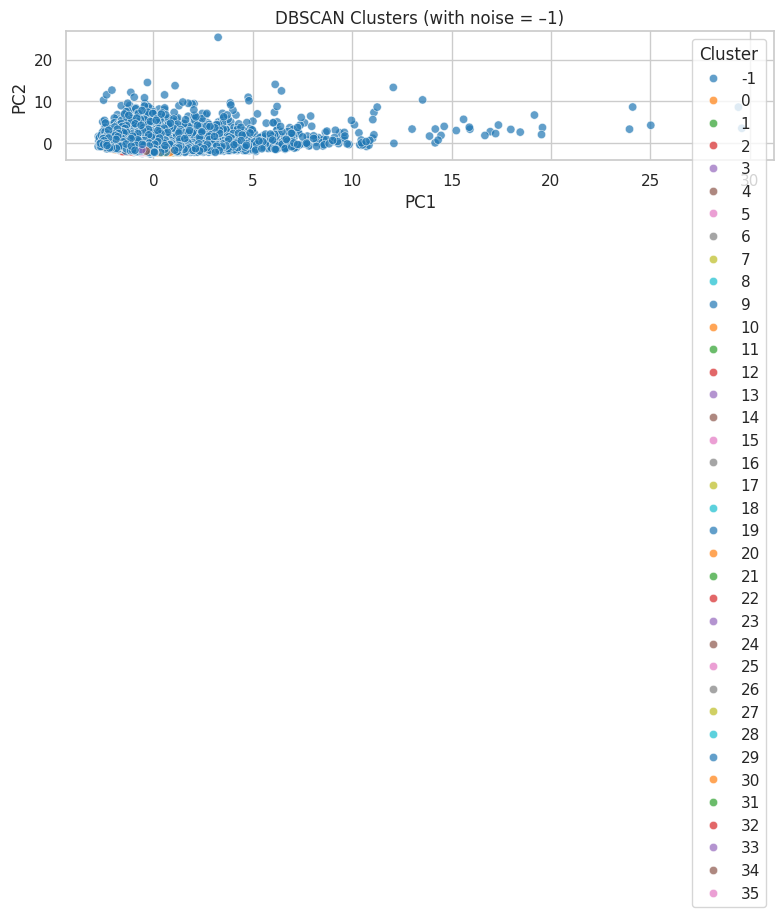

In [49]:


# Reduce to 2D if لم تفعل قبل
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(df_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_pca[:,0], y=X_pca[:,1],
    hue=labels_db,
    palette='tab10',
    legend='full',
    alpha=0.7
)
plt.title('DBSCAN Clusters (with noise = –1)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

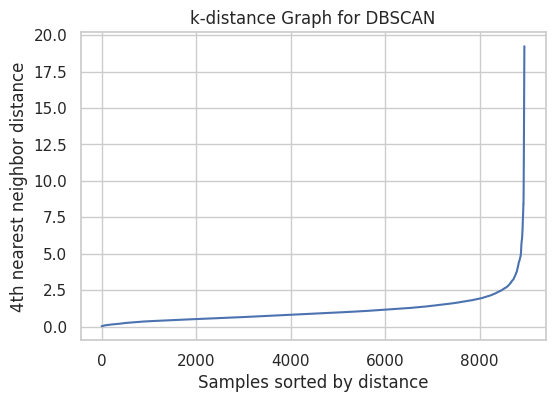

In [51]:
# ╔═ Cell 2: k-distance plot لاختيار eps
neighbors = NearestNeighbors(n_neighbors=5)
nbrs = neighbors.fit(df_scaled)
distances, _ = nbrs.kneighbors(df_scaled)

# نرتب المسافات ونرسم رابع جاران (n_neighbors-1)
k_dist = np.sort(distances[:, 4])
plt.figure(figsize=(6,4))
plt.plot(k_dist)
plt.xlabel('Samples sorted by distance')
plt.ylabel('4th nearest neighbor distance')
plt.title('k-distance Graph for DBSCAN')
plt.show()


In [52]:
# ╔═ Cell 3: Fit DBSCAN مع القيم اللي اخترتها من k-distance
eps_val = 0.7       # عدّلها بناءً على شكل الـk-distance plot
min_samples = 5     # غالباً 4–6 نقطة

db = DBSCAN(eps=eps_val, min_samples=min_samples)
labels_db = db.fit_predict(df_scaled)

# أضف التسميات للـ DataFrame الأصلي
df['cluster_dbscan'] = labels_db


In [53]:
# ╔═ Cell 4: تقييم نتائج DBSCAN
n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
n_noise    = list(labels_db).count(-1)
total_pts  = len(labels_db)

print(f"Estimated clusters (excluding noise): {n_clusters}")
print(f"Noise points: {n_noise} ({n_noise/total_pts*100:.1f}%)")
print("\nCluster sizes (including noise):")
print(df['cluster_dbscan'].value_counts())


Estimated clusters (excluding noise): 28
Noise points: 5100 (57.0%)

Cluster sizes (including noise):
cluster_dbscan
-1     5100
 0     3625
 4       43
 6       20
 2       18
 9       14
 7       10
 14      10
 12       8
 8        7
 5        7
 16       7
 15       6
 3        6
 10       6
 11       6
 19       6
 13       6
 22       5
 1        5
 18       5
 27       5
 25       5
 23       5
 20       5
 17       4
 21       3
 24       2
 26       1
Name: count, dtype: int64


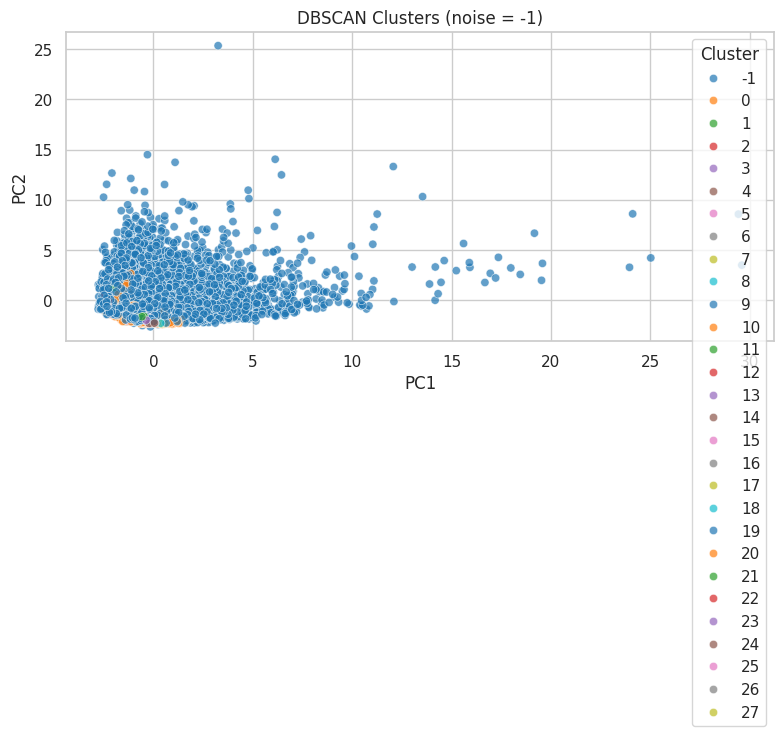

In [54]:
# ╔═ Cell 5: Visualize DBSCAN clusters in PCA space


pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(df_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_pca[:,0], y=X_pca[:,1],
    hue=labels_db,
    palette='tab10',
    legend='full',
    alpha=0.7
)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('DBSCAN Clusters (noise = -1)')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


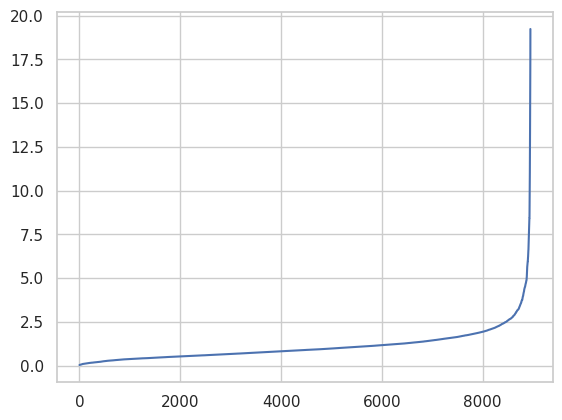

In [63]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=5).fit(df_scaled)
dists, _ = neigh.kneighbors(df_scaled)
k_dist = sorted(dists[:, 4])
plt.plot(k_dist); plt.show()

In [66]:
# 2️⃣ Apply DBSCAN
dbscan = DBSCAN(eps=2, min_samples=5)
df['cluster_dbscan'] = dbscan.fit_predict(df_scaled)

# 3️⃣ Print cluster & noise counts
n_clusters = len(set(df['cluster_dbscan'])) - (1 if -1 in df['cluster_dbscan'] else 0)
n_noise    = (df['cluster_dbscan'] == -1).sum()
print(f"Estimated clusters (excl. noise): {n_clusters}")
print(f"Noise points %: {n_noise/len(df)*100:.1f}%\n")

# 4️⃣ Numeric-only summary per DBSCAN cluster
cluster_summary = (
    df
    .groupby("cluster_dbscan")
    .mean(numeric_only=True)
    .round(2)
)
display(cluster_summary)

Estimated clusters (excl. noise): 3
Noise points %: 6.7%



,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster_kmeans,cluster_hier
cluster_dbscan,,,,,,,,,,,,,,,,,,,
-1,4294.74,0.93,4651.06,3031.34,1620.76,3642.35,0.70,0.45,0.53,0.31,11.46,51.95,9428.75,7545.31,3346.61,0.20,11.22,1.08,1.40
0,1364.51,0.87,738.82,416.56,322.51,788.30,0.48,0.18,0.35,0.12,2.66,11.98,4135.80,1314.87,664.29,0.15,11.54,2.06,1.15
1,8264.25,1.00,5298.07,1981.17,3316.89,0.00,1.00,0.57,1.00,0.00,0.00,106.40,11720.00,3625.81,2624.18,0.00,12.00,2.00,1.00


In [62]:

# 4️⃣ Hierarchical clustering (4 clusters from dendrogram cutoff)
agg = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
df['cluster_hier'] = agg.fit_predict(df_scaled)

# 5️⃣ Show cluster sizes & profile
print("Cluster sizes:\n", df['cluster_hier'].value_counts(), "\n")
print("Cluster profiles (means):")

# نختار فقط الأعمدة الرقمية
numeric_cols = df.select_dtypes(include="number").columns

# نجري التجميع على الأعمدة الرقمية فقط
cluster_summary = df[numeric_cols].groupby(df['cluster_hier']).mean().round(2)

# نظهر النتيجة
cluster_summary

Cluster sizes:
 cluster_hier
0    4875
3    2581
2    1194
1     300
Name: count, dtype: int64 

Cluster profiles (means):


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster_kmeans,cluster_dbscan,cluster_hier
cluster_hier,,,,,,,,,,,,,,,,,,,,
0,968.72,0.80,416.37,289.91,126.77,590.14,0.31,0.14,0.17,0.10,1.86,5.63,3338.38,1033.98,745.57,0.10,11.18,2.24,-0.05,0.0
1,4036.75,0.98,8549.54,5785.10,2766.44,615.78,0.93,0.70,0.72,0.06,1.62,90.06,10198.17,7837.68,2004.47,0.28,11.96,1.91,-1.00,1.0
2,4451.25,0.98,369.98,236.86,133.21,3857.38,0.21,0.09,0.13,0.43,12.50,4.79,7192.46,3070.40,1549.93,0.03,11.83,1.18,-0.82,2.0
3,1066.93,0.97,1527.41,724.78,802.82,423.68,0.91,0.31,0.79,0.07,1.78,27.69,4766.36,1725.55,571.61,0.30,11.95,1.92,-0.50,3.0


In [67]:
# ╔═ Cell: Compute PCA (2 or 3 components) on your scaled data
from sklearn.decomposition import PCA
# assume df_scaled exists and df has columns:
#   'cluster_kmeans', 'cluster_hier', 'cluster_dbscan'

# reduce to 2 dimensions
pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(df_scaled)

# (optional) reduce to 3 dimensions instead:
# pca3 = PCA(n_components=3, random_state=42)
# X_pca3 = pca3.fit_transform(df_scaled)

# build a DataFrame for plotting
df_pca = pd.DataFrame(X_pca2, columns=['PC1','PC2'])
df_pca['KMeans']      = df['cluster_kmeans']
df_pca['Hierarchical']= df['cluster_hier']
df_pca['DBSCAN']      = df['cluster_dbscan']

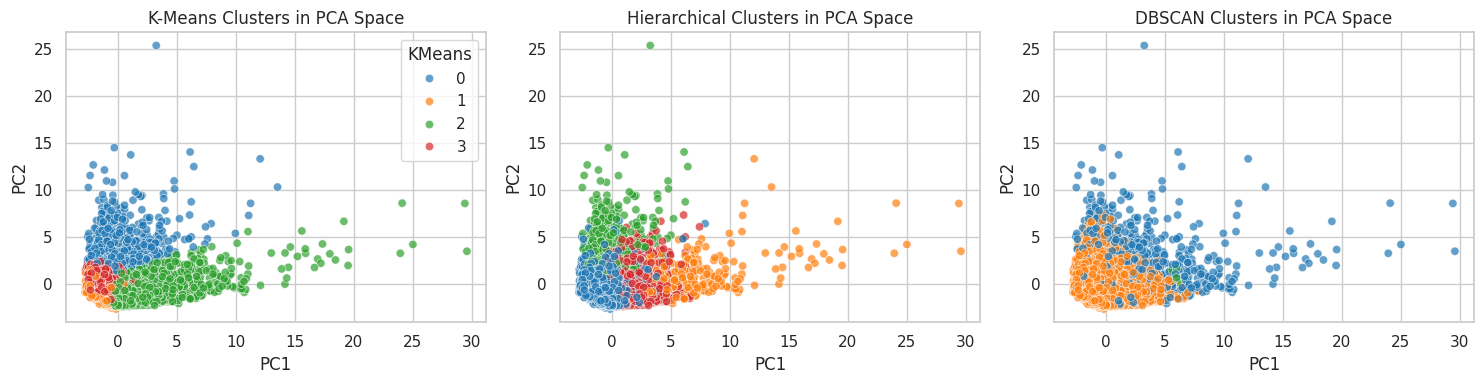

In [69]:
# ╔═ Cell: 2D visualization of all three clusterings
plt.figure(figsize=(15,4))

for i, (method, title) in enumerate([
    ('KMeans',      'K-Means Clusters'),
    ('Hierarchical','Hierarchical Clusters'),
    ('DBSCAN',      'DBSCAN Clusters')
], 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(
        data=df_pca, x='PC1', y='PC2', hue=method,
        palette='tab10', legend=(i==1), alpha=0.7
    )
    plt.title(f"{title} in PCA Space")
    plt.xlabel('PC1'); plt.ylabel('PC2')

plt.tight_layout()
plt.show()


#Model Evaluation & Interpretation

#Model Evaluation & Interpretation

In [71]:
# ╔═ Cell 1: Compute Silhouette Scores for each method
from sklearn.metrics import silhouette_score

scores = {}

# 1️⃣ K-Means
scores['KMeans'] = silhouette_score(df_scaled, df['cluster_kmeans'])

# 2️⃣ Hierarchical
scores['Hierarchical'] = silhouette_score(df_scaled, df['cluster_hier'])

# 3️⃣ DBSCAN  (exclude noise points labeled –1)
mask = df['cluster_dbscan'] != -1
scores['DBSCAN'] = silhouette_score(df_scaled[mask], df.loc[mask, 'cluster_dbscan'])

# Display
import pandas as pd
pd.Series(scores).round(3)


,0
KMeans,0.166
Hierarchical,0.160
DBSCAN,0.446


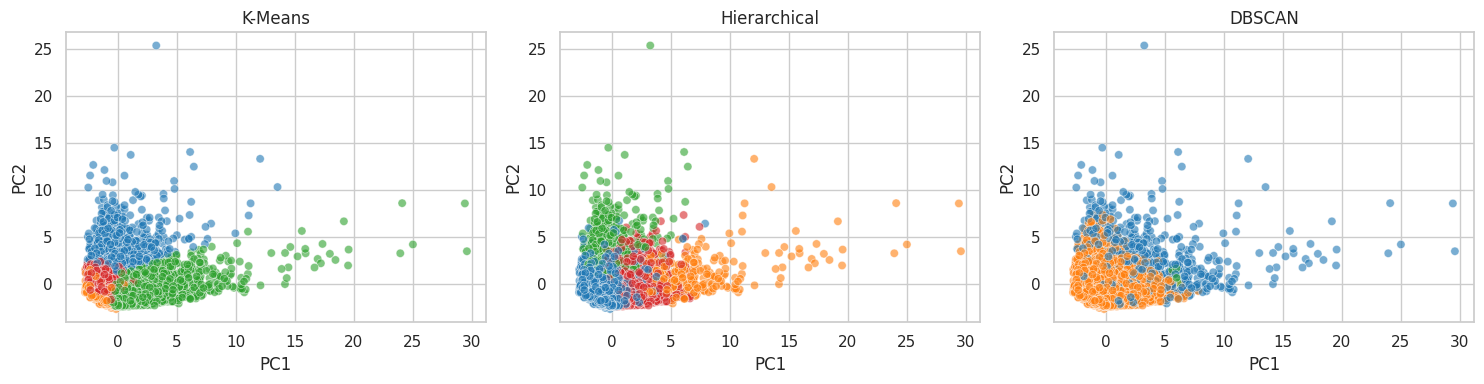

In [73]:
# ╔═ Cell 2: Visualize silhouette-colored scatterplots

methods = [
    ('cluster_kmeans',   'K-Means'),
    ('cluster_hier',     'Hierarchical'),
    ('cluster_dbscan',   'DBSCAN'),
]

plt.figure(figsize=(15,4))
for i, (col, title) in enumerate(methods, 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(
        x=df_pca['PC1'], y=df_pca['PC2'],
        hue=df[col],
        palette='tab10',
        legend=False,
        alpha=0.6
    )
    plt.title(f"{title}")
    plt.xlabel('PC1'); plt.ylabel('PC2')
plt.tight_layout()
plt.show()
